# Import Packages

In [1]:
import itertools
from pathlib import Path
import sys

from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.io import load_json_model, save_to_json

sys.path.append('../../bitome2/')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [4]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [5]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Load IcaData object

In [6]:
ica_data = load_json_model('../data/precise2.json.gz')

# Flagella Tradeoffs

In [7]:
flagella_related_ims = ['FlhDC-2', 'FlhDC-1', 'FliA']

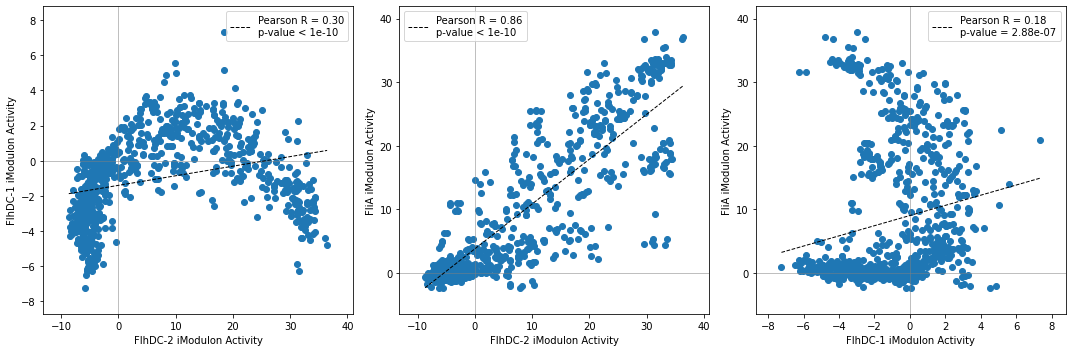

In [8]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

for ax, (flagella_im1, flagella_im2) in zip(axs, itertools.combinations(flagella_related_ims, 2)):
    compare_activities(ica_data, flagella_im1, flagella_im2, ax=ax)

plt.tight_layout()

# Shared Genes

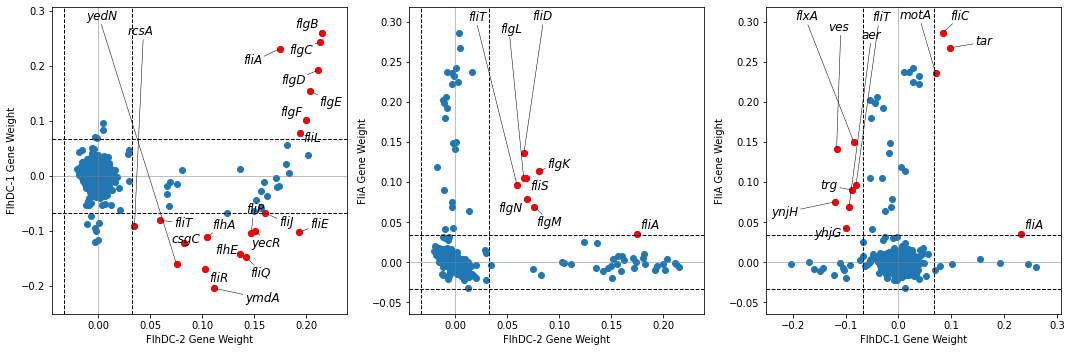

In [9]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()

for ax, (flagella_im1, flagella_im2) in zip(axs, itertools.combinations(flagella_related_ims, 2)):
    compare_gene_weights(ica_data, flagella_im1, flagella_im2, ax=ax)

plt.tight_layout()

# Motif Scores

In [11]:
# modify legacy PSSM format into Bitome 2 format
tf_pwm_db = rpwm('../data/motif_pwm_db.txt')
flhdc_pwm_old = tf_pwm_db['FlhDC']
flhdc_pssm = {base: [pos_dict[base] for pos_dict in flhdc_pwm_old] for base in 'ATCG'}

flhdc1_genes = ica_data.view_imodulon('FlhDC-1')['gene_name'].values
flhdc2_genes = ica_data.view_imodulon('FlhDC-2')['gene_name'].values
all_flhdc_genes = set(flhdc1_genes).union(flhdc2_genes)

gene2score = {}
for flhdc_gene in all_flhdc_genes:
    tus_for_gene = mg1655._gene_to_tus[ica_data.name2num(flhdc_gene)]
    gene_tu_df = mg1655.tu_table.loc[tus_for_gene]
    gene_tu_df_tss = gene_tu_df[gene_tu_df['tss'].notna()]
    scores = []
    for tu_id, tu_row in gene_tu_df_tss.iterrows():
        best_motif_match = mg1655.promoter_motif_search(tu_row.tss, tu_row.strand, flhdc_pssm)
        scores.append(best_motif_match.log_odds.values[0])
    if scores:
        gene2score[flhdc_gene] = np.mean(scores)

<AxesSubplot:xlabel='FlhDC Motif Log-Odds Score', ylabel='FlhDC-1 Gene Weight'>

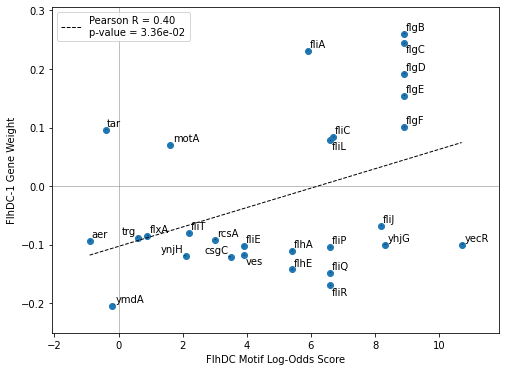

In [12]:
flhdc1_df = ica_data.view_imodulon('FlhDC-1')
flhdc1_df['score'] = flhdc1_df['gene_name'].apply(lambda gn: gene2score.get(gn, None))
flhdc1_w_motif = flhdc1_df[flhdc1_df['score'].notna()]
flhdc1_w_motif = flhdc1_w_motif.set_index('gene_name')

_, ax = plt.subplots(figsize=(8, 6))

scatterplot(
    flhdc1_w_motif['score'], flhdc1_w_motif['gene_weight'],
    xlabel='FlhDC Motif Log-Odds Score',
    ylabel='FlhDC-1 Gene Weight',
    show_labels=True,
    fit_line=True,
    legend=False,
    ax=ax
)

<AxesSubplot:xlabel='FlhDC Motif Log-Odds Score', ylabel='FlhDC-2 Gene Weight'>

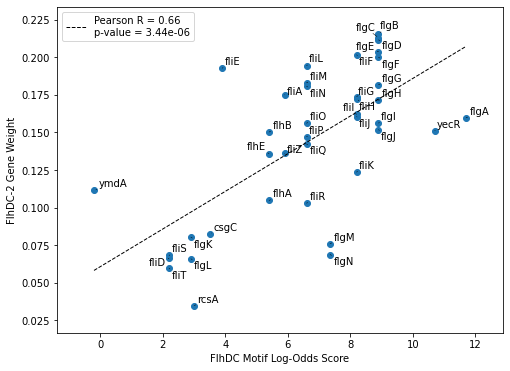

In [13]:
flhdc2_df = ica_data.view_imodulon('FlhDC-2')
flhdc2_df['score'] = flhdc2_df['gene_name'].apply(lambda gn: gene2score.get(gn, None))
flhdc2_w_motif = flhdc2_df[flhdc2_df['score'].notna()]
flhdc2_w_motif = flhdc2_w_motif.set_index('gene_name')

_, ax = plt.subplots(figsize=(8, 6))

scatterplot(
    flhdc2_w_motif['score'], flhdc2_w_motif['gene_weight'],
    xlabel='FlhDC Motif Log-Odds Score',
    ylabel='FlhDC-2 Gene Weight',
    show_labels=True,
    fit_line=True,
    legend=False,
    ax=ax
)

Just for the first gene?

# Extreme Activities

<AxesSubplot:xlabel='FlhDC-2 iModulon Activity', ylabel='FlhDC-1 iModulon Activity'>

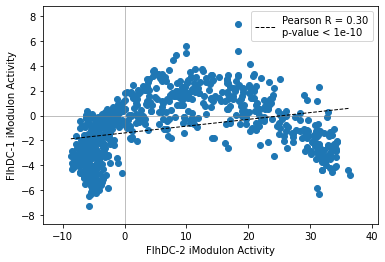

In [14]:
compare_activities(ica_data, 'FlhDC-2', 'FlhDC-1')

## Both Low

In [15]:
flh_A = ica_data.A.loc[['FlhDC-1', 'FlhDC-2']].T

both_low = flh_A[(flh_A['FlhDC-1'] < -6) & (flh_A['FlhDC-2'] < 0)].index
ica_data.sample_table.loc[both_low]

,sample_id,study,project,condition,rep_id,contact,creator,run_date,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic for selection,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,R1,R2,BAM,alignment,DOI,GEO,Published,SRX,Run,Notes,LibraryLayout,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates
ecoli_00026,oxidative__delsoxs_pq__2,Oxidative,oxidative,delsoxs_pq,2,Sangwoo Seo,Sangwoo Seo,9/18/14,Escherichia coli K-12 MG1655 del_soxS,MG1655,M9,glucose(2),NH4Cl(1),O2,None,PQ (250uM),37,7.0,Kanamycin (50 ug/mL),Batch,0.0,No,None,MiSeq,None,2,None,None,oxidative__delsoxs_pq__2.bam,97.07,doi.org/10.1016/j.celrep.2015.07.043,GSE65711,1.0,SRX871635,SRR1796605,None,PAIRED,ILLUMINA,True,True,True,True,oxidative:delsoxs_pq,True,True
ecoli_00064,ompr__wt_nacl__1,OmpR,ompr,wt_nacl,1,Sangwoo Seo,Sangwoo Seo,7/29/15,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,None,NaCl (0.3M),37,7.0,None,Batch,0.0,No,None,MiSeq,None,2,None,None,ompr__wt_nacl__1.bam,97.81,doi.org/10.1038/s41598-017-02110-7,GSE88980,1.0,SRX2254712,SRR4435464,None,PAIRED,ILLUMINA,True,True,True,True,ompr:wt_nacl,True,True
ecoli_00065,ompr__wt_nacl__2,OmpR,ompr,wt_nacl,2,Sangwoo Seo,Sangwoo Seo,7/29/15,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,None,NaCl (0.3M),37,7.0,None,Batch,0.0,No,None,MiSeq,None,2,None,None,ompr__wt_nacl__2.bam,98.81,doi.org/10.1038/s41598-017-02110-7,GSE88980,1.0,SRX2254713,SRR4435465,None,PAIRED,ILLUMINA,True,True,True,True,ompr:wt_nacl,True,True
ecoli_00121,crp__delcrp_glc__3,Crp ARs,crp,delcrp_glc,3,Haythem Latif,Haythem Latif,3/27/14,Escherichia coli K-12 MG1655 del_crp,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,Kanamycin,Batch,NaN,No,None,MiSeq,None,3,None,None,crp__delcrp_glc__3.bam,97.43,doi.org/10.1371/journal.pone.0197272,GSE64849,1.0,SRX837335,SRR1751328;SRR1751329,None,PAIRED,ILLUMINA,True,True,True,True,crp:delcrp_glc,True,True
ecoli_00466,tcs__del_btsR_01xlb__2,Two Component Systems,tcs,del_btsR_01xlb,2,Katherine Decker,Julia Kleinmanns,6/27/19,Escherichia coli K-12 MG1655 del_btsR,MG1655,01xLB,None,None,O2,None,None,37,7.0,None,Batch,NaN,No,None,None,None,2,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_01xL...,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_01xL...,/media/precise-db/processed_data/TCS__BtsR_01L...,98.40,None,None,0.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,tcs:del_btsR_01xlb,True,True
ecoli_00469,tcs__del_btsR_pyruvate__1,Two Component Systems,tcs,del_btsR_pyruvate,1,Katherine Decker,Julia Kleinmanns,6/27/19,Escherichia coli K-12 MG1655 del_btsR,MG1655,01xLB,None,None,O2,None,Pyruvate(100uM),37,7.0,None,Batch,NaN,No,None,None,None,2,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_pyru...,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_pyru...,/media/precise-db/processed_data/TCS__BtsR_pyr...,98.33,None,None,0.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,tcs:del_btsR_pyruvate,True,True
ecoli_00470,tcs__del_btsR_pyruvate__2,Two Component Systems,tcs,del_btsR_pyruvate,2,Katherine Decker,Julia Kleinmanns,6/27/19,Escherichia coli K-12 MG1655 del_btsR,MG1655,01xLB,None,None,O2,None,Pyruvate(100uM),37,7.0,None,Batch,NaN,No,None,None,None,2,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_pyru...,s3://precise-db/raw_data/TCS/2CR_HRS_BtsR_pyru...,/media/precise-db/processed_data/TCS__BtsR_pyr...,98.30,None,None,0.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,tcs:del_btsR_pyruvate,True,True
ecoli_00541,ros_tale__9_77_0pq__2,ROS TALE,ros_tale,9_77_0pq,2,Kevin Rychel,Justin Tan,9/20/19,Escherichia Coli ERS.9.77,GMOS,M9,glucose(4),NH4Cl(1),O2,None,None,37,7.0,None,Batch,NaN,Endpoint,Clonal,NextSeq,None,2,s3://precise-db/raw_data/ers2/9_77/ers2__9_77_...,s3://precise-db/raw_data/ers2/9_77/

## FlhDC-1 Low, FlhDC-2 High

In [16]:
high2_low1 = flh_A[(flh_A['FlhDC-1'] < -4) & (flh_A['FlhDC-2'] > 30)].index
ica_data.sample_table.loc[high2_low1]

,sample_id,study,project,condition,rep_id,contact,creator,run_date,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic for selection,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,R1,R2,BAM,alignment,DOI,GEO,Published,SRX,Run,Notes,LibraryLayout,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates
ecoli_00172,ica__wt_glc__4,ICA,ica,wt_glc,4,Anand Sastry,Ying Hefner,12/23/17,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,0.66,No,None,HiSeq 4000,None,4,None,None,ica__wt_glc__4.bam,94.49,None,GSE122295,1.0,SRX4993783,SRR8173230,None,PAIRED,ILLUMINA,True,True,True,True,ica:wt_glc,True,True
ecoli_00189,ica__tyr_glcn__1,ICA,ica,tyr_glcn,1,Anand Sastry,Ying Hefner,12/10/17,Escherichia coli K-12 MG1655,MG1655,M9,gluconate(4),NH4Cl(1),O2,sauer trace element mixture,tyrosine (5mM),37,7.0,None,Batch,0.57,No,None,HiSeq 4000,None,2,None,None,ica__tyr_glcn__1.bam,95.41,None,GSE122295,1.0,SRX4993800,SRR8173247,None,PAIRED,ILLUMINA,True,True,True,True,ica:tyr_glcn,True,True
ecoli_00190,ica__tyr_glcn__2,ICA,ica,tyr_glcn,2,Anand Sastry,Ying Hefner,12/10/17,Escherichia coli K-12 MG1655,MG1655,M9,gluconate(4),NH4Cl(1),O2,sauer trace element mixture,tyrosine (5mM),37,7.0,None,Batch,0.57,No,None,HiSeq 4000,None,2,None,None,ica__tyr_glcn__2.bam,95.47,None,GSE122295,1.0,SRX4993801,SRR8173248,None,PAIRED,ILLUMINA,True,True,True,True,ica:tyr_glcn,True,True
ecoli_00195,ica__bw_delpurR_cytd__1,ICA,ica,bw_delpurR_cytd,1,Anand Sastry,Sibei (Julia) Xu,10/17/18,Escherichia coli K-12 BW25113 del_purR,BW25113,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,cytidine (1mM),37,7.0,None,Batch,0.66,No,None,HiSeq 4000,None,2,None,None,ica__bw_delpurR_cytd__1.bam,94.80,None,GSE122295,0.0,SRX5975760,SRR9204650,None,PAIRED,ILLUMINA,True,True,True,True,ica:bw_delpurR_cytd,True,True
ecoli_00196,ica__bw_delpurR_cytd__2,ICA,ica,bw_delpurR_cytd,2,Anand Sastry,Sibei (Julia) Xu,10/17/18,Escherichia coli K-12 BW25113 del_purR,BW25113,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,cytidine (1mM),37,7.0,None,Batch,0.66,No,None,HiSeq 4000,None,2,None,None,ica__bw_delpurR_cytd__2.bam,92.69,None,GSE122295,0.0,SRX5975761,SRR9204651,None,PAIRED,ILLUMINA,True,True,True,True,ica:bw_delpurR_cytd,True,True
ecoli_00197,ica__ade_glc__1,ICA,ica,ade_glc,1,Anand Sastry,Sibei (Julia) Xu,10/17/18,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,adenine (100mg/L),37,7.0,None,Batch,0.78,No,None,HiSeq 4000,None,2,None,None,ica__ade_glc__1.bam,92.46,None,GSE122295,0.0,SRX5975762,SRR9204652,None,PAIRED,ILLUMINA,True,True,True,True,ica:ade_glc,True,True
ecoli_00198,ica__ade_glc__2,ICA,ica,ade_glc,2,Anand Sastry,Sibei (Julia) Xu,10/17/18,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,adenine (100mg/L),37,7.0,None,Batch,0.78,No,None,HiSeq 4000,None,2,None,None,ica__ade_glc__2.bam,92.96,None,GSE122295,0.0,SRX5975763,SRR9204653,None,PAIRED,ILLUMINA,True,True,True,True,ica:ade_glc,True,True
ecoli_00299,nquinone__delpdhR__1,Naphthoquinone,nquinone,delpdhR,1,Amitesh Anand,Amitesh Anand,8/7/18,Escherichia coli del_pdhR,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,0.70,No,None,HiSeq 4000,None,2,s3://precise-db/raw_data/nquinone/EEP_HRS_pdhR...,s3://precise-db/raw_data/nquinone/EEP_HRS_pdhR...,None,NaN,None,None,1.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,nquinone:delpdhR,True,True
ecoli_00300,nquinone__delpdhR__2,Naphthoquinone,nquinone,delpdhR,2,Amitesh Anand,Amitesh Anand,8/7/18,Escherichia coli del_pdhR,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,0.70,No,None,HiSeq 4000,None

## FlhDC-1 High, FlhDC-2 Mid

In [17]:
high1 = flh_A[(flh_A['FlhDC-1'] > 4)].index
ica_data.sample_table.loc[high1]

,sample_id,study,project,condition,rep_id,contact,creator,run_date,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic for selection,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,R1,R2,BAM,alignment,DOI,GEO,Published,SRX,Run,Notes,LibraryLayout,Platform,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation,full_name,passed_similar_replicates,passed_number_replicates
ecoli_00125,glu__glu_ale3__1,Glucose Evolution,glu,glu_ale3,1,Ryan LaCroix,Richard Szubin,4/15/13,Escherichia coli GLU.3.412.1,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,1.01,Endpoint,Clonal,MiSeq,GLU A3 F412 I1,1,None,None,glu__glu_ale3__1.bam,98.88,doi.org/10.1128/AEM.02246-14,GSE61327,1.0,SRX699437,SRR1573437,None,PAIRED,ILLUMINA,True,True,True,True,glu:glu_ale3,True,False
ecoli_00129,glu__glu_ale8__1,Glucose Evolution,glu,glu_ale8,1,Ryan LaCroix,Richard Szubin,5/1/13,Escherichia coli GLU.8.380.1,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,0.99,Endpoint,Clonal,MiSeq,GLU A8 F380 I1,1,None,None,glu__glu_ale8__1.bam,96.96,doi.org/10.1128/AEM.02246-14,GSE61327,1.0,SRX699442,SRR1573442,None,PAIRED,ILLUMINA,True,True,True,True,glu:glu_ale8,True,False
ecoli_00130,glu__glu_ale9__1,Glucose Evolution,glu,glu_ale9,1,Ryan LaCroix,Richard Szubin,5/18/13,Escherichia coli GLU.9.433.1,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,1.01,Endpoint,Clonal,MiSeq,GLU A9 F422 I1,1,None,None,glu__glu_ale9__1.bam,97.96,doi.org/10.1128/AEM.02246-14,GSE61327,1.0,SRX699443,SRR1573443,None,PAIRED,ILLUMINA,True,True,True,True,glu:glu_ale9,True,False
ecoli_00131,glu__glu_ale10__1,Glucose Evolution,glu,glu_ale10,1,Ryan LaCroix,Richard Szubin,5/19/13,Escherichia coli GLU.10.418.1,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,37,7.0,None,Batch,1.02,Endpoint,Clonal,MiSeq,GLU A10 F418 I1,1,None,None,glu__glu_ale10__1.bam,98.42,doi.org/10.1128/AEM.02246-14,GSE61327,1.0,SRX699444,SRR1573444,None,PAIRED,ILLUMINA,True,True,True,True,glu:glu_ale10,True,False
ecoli_00136,42c__42c_ale4__1,42C Evolution,42c,42c_ale4,1,Ryan LaCroix,Richard Szubin,5/2/13,Escherichia coli 42C.4.161.1,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,None,42,7.0,None,Batch,1.03,Endpoint,Clonal,MiSeq,42C A4 F161 I1,1,None,None,42c__42c_ale4__1.bam,97.07,doi.org/10.1093/molbev/msu209,GSE132442,1.0,SRX6027828,SRR9257367,None,PAIRED,ILLUMINA,True,True,True,True,42c:42c_ale4,True,False
ecoli_00477,tcs__del_cusR_lb__1,Two Component Systems,tcs,del_cusR_lb,1,Katherine Decker,Julia Kleinmanns,6/27/19,Escherichia coli K-12 MG1655 del_cusR,MG1655,LB,None,None,O2,None,None,37,7.0,None,Batch,NaN,No,None,None,None,2,s3://precise-db/raw_data/TCS/2CR_HRS_CusR_LB_1...,s3://precise-db/raw_data/TCS/2CR_HRS_CusR_LB_1...,/media/precise-db/processed_data/TCS__CusR_LB_...,98.42,None,None,0.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,tcs:del_cusR_lb,True,True
ecoli_00478,tcs__del_cusR_lb__2,Two Component Systems,tcs,del_cusR_lb,2,Katherine Decker,Julia Kleinmanns,6/27/19,Escherichia coli K-12 MG1655 del_cusR,MG1655,LB,None,None,O2,None,None,37,7.0,None,Batch,NaN,No,None,None,None,2,s3://precise-db/raw_data/TCS/2CR_HRS_CusR_LB_2...,s3://precise-db/raw_data/TCS/2CR_HRS_CusR_LB_2...,/media/precise-db/processed_data/TCS__CusR_LB_...,98.28,None,None,0.0,None,None,None,PAIRED,ILLUMINA,True,True,True,True,tcs:del_cusR_lb,True,True


# Notes

- FlhDC-2 and FlhDC-1 activities show intriguing horseshoe shape
- FlhDC-2 and FliA are highly correlated (thus FliA and FlhDC-1 show similar horseshoe)
- flhDC (expression of FlhDC) does not correlate much with any of the major flagella regulators

- FlhDC-1 and FlhDC-2 share a LOT of genes; however, FlhDC-2 has all positive gene weights, while FlhDC-1 has a 50/50 split of positive and negative gene weights
    - Positive FlhDC-1, Positive FlhDC-2:
        - fliA (Sigma 28)
        - fliL (flagella-related, exact function unknown; first member of 7-gene operon)
        - flgBCDEF (basal body/hook components)
    - Negative FlhDC-1, Positive FlhDC-2: 
        - rcsA (regulator)
        - yedN (y-gene)
        - csgC (curlin chaperone)
        - flagellar export (fliT, fliJ, flhA, fliP, flhE, fliQ, fliR)
        - yecR (lipoprotein, regulated by FlhDC)
        - fliE (hook component)
        - ymdA (uncharacterized; related to biofilm through deletion; could we suggest function?)
- FlhDC-2 and FliA share positively-weighted genes:
    - fliDST (filament cap, two chaperones respectively)
    - flgKL (hook subunits)
    - flgM (anti sigma factor for FliA; https://www.ecocyc.org/gene?orgid=ECOLI&id=G369)
    - flgN (flagellar chaperone)
- FliA and FlhDC-1, similar to the FlhDC-1/2 tradeoff; FliA is all positive gene weights. The shared genes are largely distinct from those in FlhDC-1/2:
    - Positive FlhDC-1, Positive FliA:
        - fliC (the actual flagellum monomer)
        - tar (chemotaxis receptor)
        - motA (stator component of flagellar motor)
    - Negative FlhDC-1, Positive FliA:
        - fliT (chaperone)
        - flxA (maybe vestigial)
        - aer (aerotaxis sensor)
        - ves (little known)
        - trg (chemotaxis receptor, different substrates than tar)
        - ynjH, yhjG (y-genes)

# ToDo

- make those plots of individual gene expresssions vs FlhDC-1/2 activity (some from each side of FlhDC-1/2 shared pool)
- reach out to Joe Pogliano about this question generally